# Рекомендация тарифорв

# 1. Введение

## 1.1 Описание данных
параметры датасета:

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах
- messages — количество sms-сообщений
- mb_used — израсходованный интернет-трафик в Мб
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)


## 1.2 Описание проекта
**Задание:** Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import numpy as np
import os

import graphviz
import os

In [2]:
path1 = 'users_behavior.csv'
path2 = '/datasets/users_behavior.csv'

if os.path.exists(path1):
    df = pd.read_csv(path1)
elif os.path.exists(path2):
    df = pd.read_csv(path2)
else:
    print(f'файл {path1} не найден')

In [3]:
# посмотрим на фрагмент датасета
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# посмотрим на основные параметры датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
# разобьем датаесет на тренировочную тестовую выборки. 
# X_train и y_train - то на чему буджет обучаться модель. Обучение модели будет проводиться с использованием кросс-валидации.
# X_test и y_test - то на чему будет проверяться качество модели. 
# размер тестовой выборки возьмем стандартный: 25% от всего объема
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_ultra', axis=1), df['is_ultra'], test_size=0.25, random_state=123)

In [6]:
# убедимся, что форма массивов корректная
print('X_train.shape =', X_train.shape)
print('X_test.shape =', X_test.shape)
print('y_train.shape =', y_train.shape)
print('y_test.shape =', y_test.shape)

X_train.shape = (2410, 4)
X_test.shape = (804, 4)
y_train.shape = (2410,)
y_test.shape = (804,)


# 2 Исследование качества моделей

## 2.1 Логистическая регрессия

Посмотрим какой будет результат логистической регрессии при дефолтных значениях.

In [7]:
%timeit
logreg_base_model = LogisticRegression()
logreg_base_model.fit(X_train, y_train)
logreg_base_prediction = logreg_base_model.predict(X_test)
print('accuracy =', accuracy_score(y_test,  logreg_base_prediction))

accuracy = 0.7064676616915423


Отойдем в сторонку от предложенных в тренажере методов выбора лучшего параметра через циклы и применим один из наиболее популярных способов поиска наилучшего набора параметров, объект класса библиотеки sklearn - GridSearchCV. Данный метод также позволяет применить к обучающему набору кросс-валидацию (перекрестную проверку)

**Примечание:** В рамках данной работы отнесемся к модели и гиперпарамтрам сейчас как к черному ящику, т.е. попробуем перебрать различные параметры фактически на удачу.

In [8]:
# зададим набор параметров
param_grid_log = {
    'C': range(1, 11),
    'tol': [1e-4, 1e-5, 0.5e-4],
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial']}

# зададим параметры стратифицированной к-блочной проверки: разобьем тренировочный набор случайным образом на 5 частей.
cv_log = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# зададим модель
logreg_model = LogisticRegression(random_state=123)
# создадим объект класса GridSearchCV
gridsearch_log = GridSearchCV(estimator=logreg_model, param_grid=param_grid_log, cv=cv_log, scoring='accuracy')
# применим метод fit - обучим модель
gridsearch_log.fit(X_train, y_train)
# применим метод predict - спрогнозируем целевую переменную на отложенной тестовой выборке
gridsearch_log_prediction = gridsearch_log.predict(X_test)
# посмотрим на результат и выведем лучшие параметры
print('accuracy =', accuracy_score(y_test,  gridsearch_log_prediction))
print('best_params = ', gridsearch_log.best_params_)

accuracy = 0.7437810945273632
best_params =  {'C': 1, 'class_weight': None, 'multi_class': 'multinomial', 'tol': 0.0001}


Чтож, score подрос достаточно не плохо - плюс 4%. Наверное, можно как-то еще улучшить модель, но интереснее, пожалуй, что покажут другие модели.

## 2.2 Дерево решений

Посмотрим какой будет результат дерева решений при дефолтных значениях.

In [9]:
tree_base_model = DecisionTreeClassifier(random_state=42)
tree_base_model.fit(X_train, y_train)
base_tree_prediction = tree_base_model.predict(X_test)
print('accuracy =', accuracy_score(y_test,  base_tree_prediction))

accuracy = 0.7101990049751243


In [10]:
# посмотрим на параметры дерева решений
tree_base_model.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')>

изменяя random_state можно получить 0.70 +-0.01 
остановимся на значении 42, т.к. при нём score для Дерева решений получился чуть выше чем для Логистической регрессии.

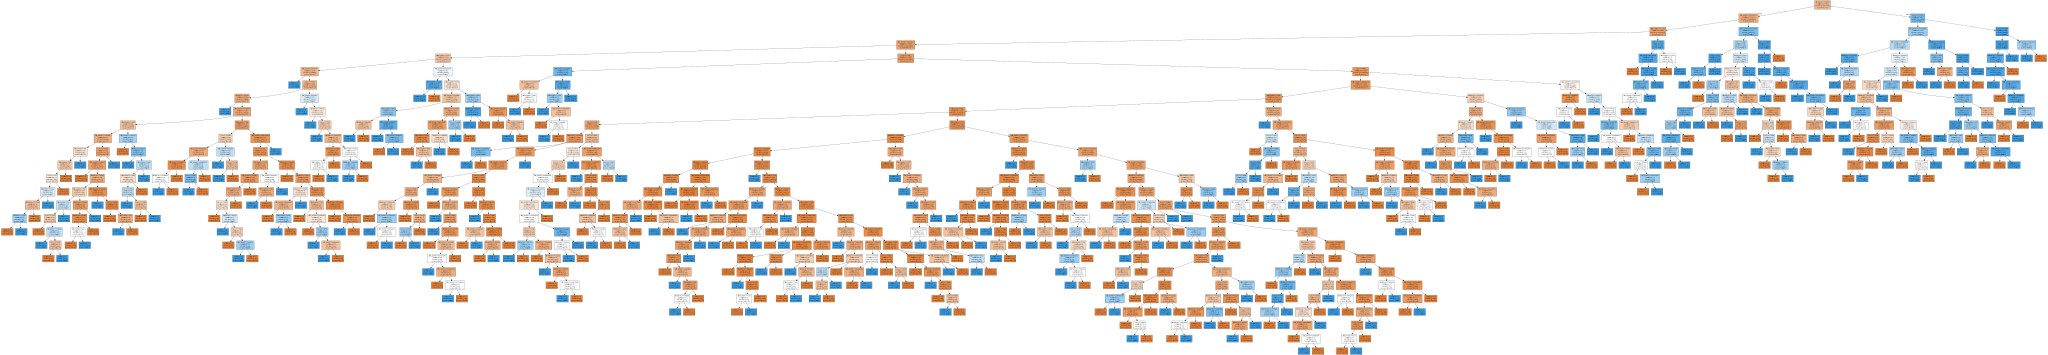

In [11]:
# визуализируем дерево решений.
feature_list = df.columns.to_list()
feature_list.remove('is_ultra')
export_graphviz(tree_base_model, out_file='tree.dot', class_names=['ultra','smart'], feature_names=feature_list, impurity=False, filled=True)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Так, судя по всему, выглядит ~~дерево курильщика~~ переобученное дерево решений. Количество  узлов и глубина дерева получились достаточно большими, при этом  количество выборок (min_samples_split) достаточно маленькое.

Попробуем немного поднастроить гиперпараметры дерева

In [12]:
params_grid_tree = {
    'max_depth': range(1, 6),
    'max_leaf_nodes': range(2, 20),
    'criterion': ['gini','entropy'],
    'min_samples_split':[10,50,100]
}

cv_tree = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
tree_model = DecisionTreeClassifier(random_state=42)

gridsearch_tree = GridSearchCV(estimator=tree_model, param_grid=params_grid_tree, cv=cv_tree, scoring='accuracy')
gridsearch_tree.fit(X_train, y_train)
gridsearch_tree_prediction = gridsearch_tree.predict(X_test)
tree_best_params = gridsearch_tree.best_params_
print('accuracy =', accuracy_score(y_test,  gridsearch_tree_prediction))
print('best_params = ', tree_best_params)

accuracy = 0.8022388059701493
best_params =  {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 6, 'min_samples_split': 10}


посмотрим на визуализацию дерева решений с улучшенными гиперпараметрами

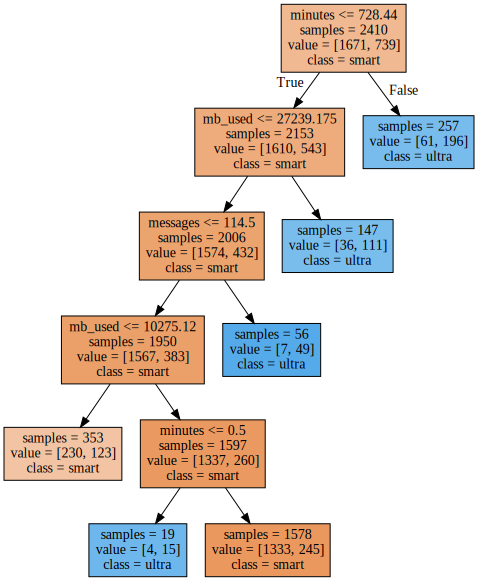

In [13]:
tuned_DecisionTree = DecisionTreeClassifier(random_state = 42, 
                                            criterion = tree_best_params['criterion'],
                                            max_depth = tree_best_params['max_depth'],
                                            max_leaf_nodes = tree_best_params['max_leaf_nodes'],
                                            min_samples_split = tree_best_params['min_samples_split'] )
tuned_DecisionTree.fit(X_train, y_train)

export_graphviz(tuned_DecisionTree, out_file='tree2.dot', class_names=['smart', 'ultra'], feature_names=feature_list, impurity=False, filled=True)
with open('tree2.dot') as f:
    dot_graph2 = f.read()
graphviz.Source(dot_graph2)

А так ~~выглядит дерево здорого человека~~ дерево стало значительно компактнее и читаемее, что, собственно, от него и требуется. Можно даже передать его в отдел маркетинга 0-)

In [14]:
# посмотрим на все парметры дерева
tuned_DecisionTree.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')>

сопоставляя диаграмму с полученными параметрами видно что:
1. глубина дерева дйствительно 5
2. узлов 5, при max_leaf_nodes=6. сходится
3. минимальное количество выборок = 19, при min_samples_split=10. сходится 

посмотрим на важность параметров

In [15]:
for name, score in zip(feature_list, tuned_DecisionTree.feature_importances_):
    print(name, score)

calls 0.0
minutes 0.4566115120948123
messages 0.1797158719612331
mb_used 0.36367261594395456


И да! на диаграмме было не заметно, но, получается, количество звонков вообще никак не влияет на тариф. Только Общее количество минут, мегабайт и сообщений (как и на диаграмме, но уже циферками :)

## 2.3 Случайный лес

Посмотрим на результат с дефолтными парметрами

In [16]:
randomforest_base_model = RandomForestClassifier(random_state=42)
randomforest_base_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
base_randomforest_prediction = randomforest_base_model.predict(X_test)
print('accuracy =', accuracy_score(y_test,  base_randomforest_prediction))

accuracy = 0.7985074626865671


In [18]:
randomforest_base_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>

Еще интереснее! С дефолтными парамтерами Случайный лес выдал результат выше чем с "Дерево" настроенными ..
Попробуем немного "подтюнить" Случайный лес

In [19]:
%%time
params_grid_randomforest = {
    #'n_estimators': [60,61,62], # Лучший параметр
    'min_samples_split': range(20,40,10),
    'max_features': ['sqrt'], # Лучший параметр
    'max_depth': [9,10,11], # 
    'n_jobs': [-1],
    #'min_samples_leaf': range(1, 201, 20),
    'bootstrap' : [True]} # Лучший параметр


cv_randomforest = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
randomforest_model = RandomForestClassifier(random_state=135)

gridsearch_randomforest = GridSearchCV(estimator=randomforest_model, param_grid=params_grid_randomforest, cv=cv_randomforest, scoring='accuracy')
gridsearch_randomforest.fit(X_train, y_train)
gridsearch_randomforest_prediction = gridsearch_randomforest.predict(X_test)
randomforest_best_params = gridsearch_randomforest.best_params_
print('accuracy =', accuracy_score(y_test,  gridsearch_randomforest_prediction))
print('best_params = ', randomforest_best_params)

accuracy = 0.8097014925373134
best_params =  {'bootstrap': True, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_jobs': -1}
Wall time: 31 s


Наверное как-то можно еще улучшить модель, но это, надеюсь, будем проходить в следующих подулях. Переходим к проверке на "вменяемость"

## 3. Дополнительное задание. Проверьте модели на "вменяемость"

Для проверки на адекватность в качестве baseline (хоть и задним числом) возьмем из библиотеки sklearn dummyclassifier и посчмотрим не его score

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf_prediction = dummy_clf.predict(X_test)
print('accuracy =', accuracy_score(y_test,  dummy_clf_prediction))
print('best_params = ', randomforest_best_params)

accuracy = 0.6940298507462687
best_params =  {'bootstrap': True, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_jobs': -1}


Похоже есть расбалансировка классов. Проверим

In [21]:
smart_from_total = round(df.loc[df['is_ultra']==0, 'is_ultra'].count()/len(df),3)
print(f'В исходном датасете класс smart занимает {smart_from_total} от общего числа записей')

В исходном датасете класс smart занимает 0.694 от общего числа записей


т.е. получается, если просто в лоб всем предлагать тафриф smart, то можно попадать с вероятностью 69% .. не плохо. А если сделать по умному (с применением ML), то попадание можно увеличить на 11%.. (если только на данном датасете, т.е. без допфичей)

## 4. Общие выводы

В процессе работы над проектом были построены модели с настроенными гиперпараметрами и без настроек для следующих моделей:
- DummyClassifier
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier


Модели перечислены в порядке возрастания предиктивной силы, при этом модели с настройками гиперпараметров модели показали значения выше, чем без настроек (что логично)

Значения, полученные для разных моделей при различных настройках сведены в таблицу 1.

таблица 1. Результаты значений моделей при с настройкми и с дефолтными значениями.

|Модель | baseline | настроенная модель|
|---------------|------------|-------------------|
|dummyClassifier| 0.694| - |
|LogisticRegression   | 0.706|0.7437|
|DecisionTreeClassifier|0.7101|0.802|
|RandomForestClassifier|0.805|0.809|

**Выводы**
1. Ввиду дисбаланса классов просто всем клиентам предлагая тариф smart можно угадывать с вероятностью примерно 69% (по метрике accuracy)
2. Если применить ML, можно предсказывать подходящий тариф с точностью примерно на 11% выше
3. Лучший результат ожидаемо дала модель "Случайный лес", худший - Логистическая регрессия. 
4. Модель "Дерево решений" показало достаточно высокую предиктивную способность и достаточно простоую логику принятия решений
5. Параметр "количество звонков" для расчета модели "Дерево решений" можно исключить, он ни на что не влияет. Но на других моделях это надо проверить. Но скорее всего score или не изменится или даже повсится.
6. Ранжируя в порядке значимости параметров можно перечислить их так: 
    1. minutes
    2. messages
    3. mb_used